In [1]:
import sys
sys.path.append('/Users/CHJ/文稿/weekly_report/CSOM/minisom')
sys.path.append(r'/Users/CHJ/文稿/无人机sar/yamakawa/pi_data/SAR_program')

import cmaps
import cmath
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import SA_func as sa
import seaborn as sns
import sympy as sp
from skimage import io

## defining the parameters
ch = 8 # channel
ad_samp_point = 512  # sampling points in the range direction
az_n = 2000 # pixels in the azimuth direction
az_dt =0.01
light_speed = sa.light_speed
df = sa.df
dr = sa.dr
ad_samp_point = sa.ad_samp_point
chirp_rate = sa.chirp_rate
d_tau = df / chirp_rate
dir_name = ""
add_name = ""
filename = "fft_data"

fft_data = sa.read_fft_data(filename)
data = sa.code_V_convert(fft_data)
raw_data = sa.get_raw_data(data)
# index = [700, 1200, 0, 50]
index = [0, 2000, 0, 50]
az_s_index = index[0]
az_e_index = index[1]
az_len = az_e_index - az_s_index
rg_s_index = index[2]
rg_e_index = index[3]
rg_len = rg_e_index - rg_s_index
plt.figure(figsize = (12,8))

# # ampを抽出,amp_dataは20log化データ
# data = raw_data[0] #raw_data (8,2000,512)
# amp_data = 20 * np.log10(np.abs(data[az_s_index:az_e_index, rg_s_index:rg_e_index]))
# phase_data = np.angle(data[az_s_index:az_e_index, rg_s_index:rg_e_index])
# amp_phase = np.stack((amp_data, phase_data),axis=-1)
# amp_phase_two_column = np.reshape(amp_phase, (-1, 2))
# "amp_data = np.clip(amp_data, -30, 30) #（500，50）"

''' 8 channelのTX-RX振幅と位相を(500,50,16)に変換'''

# (500,50,2,8)に変換、2の一つのベクトルに8チャンネルのampやphase数値が入っている
complex_val = []
for i in range(8):
    data = raw_data[i] #raw_data (8,2000,512)
    # amp_data = 20 * np.log10(np.abs(data[az_s_index:az_e_index, rg_s_index:rg_e_index]))
    amp_data = np.abs(data[az_s_index:az_e_index, rg_s_index:rg_e_index])
    amp_data = np.reshape(amp_data, (amp_data.shape[0], amp_data.shape[1], 1))
    phase_data = np.angle(data[az_s_index:az_e_index, rg_s_index:rg_e_index])
    phase_data = np.reshape(phase_data, (phase_data.shape[0], phase_data.shape[1], 1))
    # Make (500, 50, 8)
    x = 0
    complex_val_i = np.zeros((amp_data.shape[0], amp_data.shape[1], 1),dtype=complex)
    for amp_data_i, phase_data_i in zip(amp_data, phase_data):
        y = 0
        for amp_data_j, phase_data_j in zip(amp_data_i, phase_data_i):
            complex_val_i[x,y,0] = amp_data_j*cmath.exp(1j*phase_data_j)
            y += 1
        x += 1
    complex_val.append(complex_val_i)
complex_val = np.stack(complex_val, axis=-1)


# # (500,50,8,2)に変換、8チャンネルの一つのベクトルにampとphase数値が入っている
# amp_phase = np.zeros((500, 50, 8, 2))

# for i in range(8):
#     data = raw_data[i]  # raw_data (8, 2000, 512)
#     amp_data = 20 * np.log10(np.abs(data[az_s_index:az_e_index, rg_s_index:rg_e_index]))
#     phase_data = np.angle(data[az_s_index:az_e_index, rg_s_index:rg_e_index])
#     amp_phase_i = np.stack((amp_data, phase_data), axis=-1)
#     amp_phase[:, :, i, :] = amp_phase_i


complex_val_8_column = np.reshape(complex_val, (-1, 8))
# amp_phase_16_column = np.reshape(amp_phase, (-1, 8, 2))

# #sar_data
# all_sar_data = np.zeros(((index[1] - index[0]), (index[3] - index[2])), dtype = np.complex64)
# all_sar_data = sa.back_projection(raw_data, index, conv_az_n, spline_d_array)


# target_amp_data = 20 * np.log10(np.abs(data[900:1000, 12:16]))
# target_phase_data = np.angle(data[900:1000, 12:16])
# target_data= np.hstack((target_amp_data, target_phase_data))
# target_two_column = np.reshape(target_data, (-1, 2))

# # 绘制散点图
# plt.scatter(amp_phase_two_column[:,0], amp_phase_two_column[:,1], s=75, c='purple', alpha=0.5)
# plt.scatter(target_two_column[:,0], target_two_column[:,1], s=75, c='red', alpha=0.5)

# # 添加标题和标签
# plt.title('Scatter Plot')
# plt.xlabel('amp')
# plt.ylabel('phase')

<Figure size 1200x800 with 0 Axes>

['/Users/CHJ/文稿/weekly_report/CSOM', '/Users/CHJ/miniforge3/envs/practice/lib/python39.zip', '/Users/CHJ/miniforge3/envs/practice/lib/python3.9', '/Users/CHJ/miniforge3/envs/practice/lib/python3.9/lib-dynload', '', '/Users/CHJ/miniforge3/envs/practice/lib/python3.9/site-packages', '/Users/CHJ/文稿/weekly_report/CSOM/minisom', '/Users/CHJ/文稿/无人机sar/yamakawa/pi_data/SAR_program']
training...
quantization...
building new image...
Class 1 :
[(1.0621149513245578, -0.242246756380424/pi), (0.9074829726364523, 0.398347185678402/pi), (1.212701892201328, -0.299336411255037/pi), (2.262985448260943, 0.129011853261411/pi), (1.5090431719452475, -0.0806219041360219/pi), (0.40465923612786775, 0.430935869027623/pi), (1.5910859400255266, -0.127321333935277/pi), (1.2519005389690225, 0.0695128258378029/pi)]
Class 2 :
[(1.2146116175404829, -0.363330200440534/pi), (2.1806473016011196, 0.177515490901331/pi), (0.8126711032975878, -0.760402808270323/pi), (7.014455080040154, -0.801771239136844/pi), (3.04752751997

Text(0.5, 1.0, 'Clustering Result')

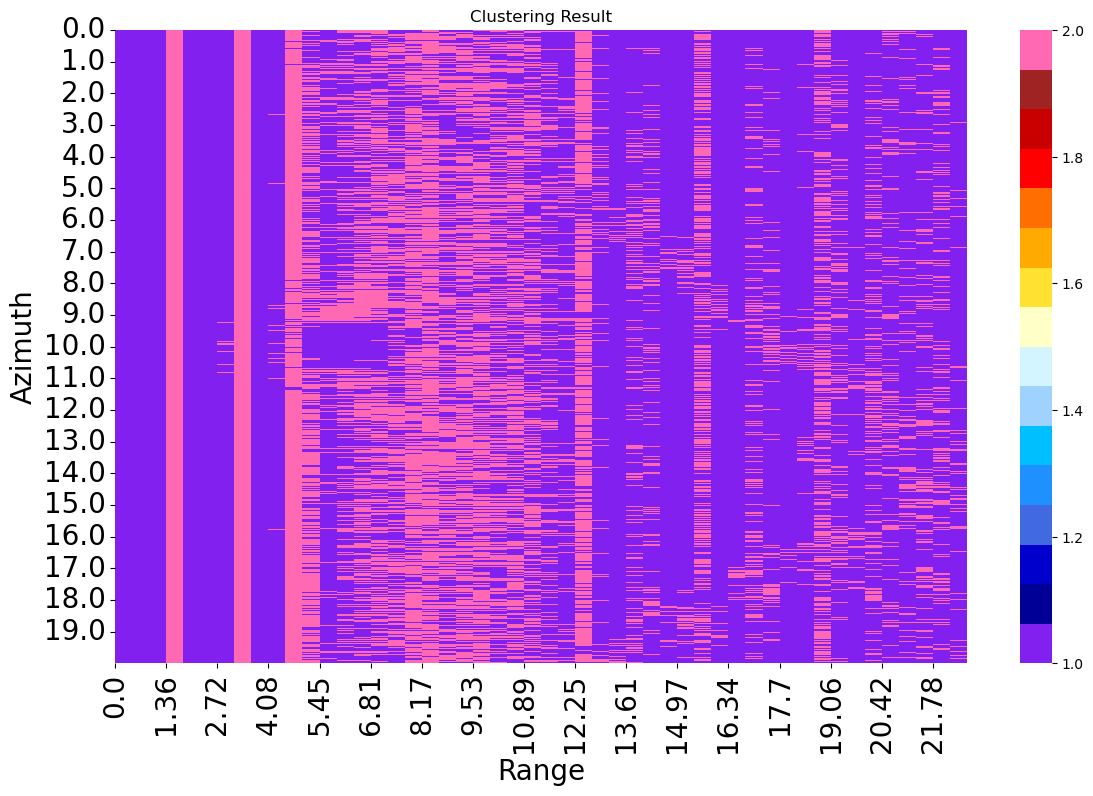

In [3]:
# sys.path.insert(0,'/Users/CHJ/文稿/weekly_report/CSOM/minisom') # when the module name is same as built-in module, can not use from ... import ...
print(sys.path) # check if the path is added in front of the system path

import CSOM_ring

# Reshaping the pixels matrix
# pixels = np.reshape(img, (img.shape[0]*img.shape[1], 1))
pixels = complex_val_8_column
# SOM initialization and training
print('training...')
som = CSOM_ring.MiniSom_ring(2, 8, sigma=0.,
              learning_rate=0.01, neighborhood_function='bubble', activation_distance='hermitian_product')
# som.random_weights_init(pixels)
starting_weights = som.get_weights().copy()  # Saving the starting weights
som.train_ring(pixels, 1500000, random_order=True, verbose=False, use_epochs=False)

print('quantization...')
qnt = som.quantization(pixels)  # Quantize each pixels of the image

print('building new image...')
clustered = np.zeros((*amp_data.shape, 8), dtype=complex)
for i, q in enumerate(qnt):  # Place the quantized values into a new image, i=index, q=quantized value
    clustered[np.unravel_index(i, shape=(amp_data.shape[0], amp_data.shape[1]))] = q
labelled = np.zeros((*amp_data.shape, 1), dtype=np.float64)
flattened = clustered.reshape(-1, clustered.shape[-1])

# Initialize class labels and current label
class_labels = np.zeros((flattened.shape[0],), dtype=int)
current_label = 1
# Traverse the flattened array
for i, vector in enumerate(flattened):
    # If the vector is already labeled, skip it
    if class_labels[i] != 0:
        continue
    # Label the vector if it is not labeled before
    class_labels[i] = current_label
    # Search for the same vector in the remaining vectors, and label them
    for j in range(i+1, flattened.shape[0]):
        if np.array_equal(vector, flattened[j]):
            class_labels[j] = current_label
    current_label += 1
# Print the class labels and the corresponding vectors
for i in range(1, 9):
    print("Class", i, ":")
    for j in range(len(class_labels)):
        if class_labels[j] == i:
            print([(cmath.polar(cur)[0], cmath.polar(cur)[1]/math.pi/sp.pi) for cur in flattened[j]])
            break
# Reshape the class labels to the shape of the original image
class_labels = class_labels.reshape(clustered.shape[:-2])

print('done.')


# # amp heatmap
# for i in range(8):
#     all_font = 20
#     plt.figure(figsize=(12, 8))
#     sns.heatmap(clustered[:,:,i], cmap="precip2_15lev",vmin = -30, vmax = 30) # amp image, 0-7
#     name = ["", "range [m]", "azimuth [s]"]
#     dx = d_tau * light_speed / 2 / 2
#     dy = 0.01
#     x_step = int(rg_len / 25) + 1
#     y_step = int(az_len / 20)
#     plt.xticks(np.arange(0, rg_e_index - rg_s_index, step = x_step), np.round(np.arange(rg_s_index * dx, rg_e_index * dx, step = dx * x_step), 2), fontsize = all_font, rotation = 90)
#     plt.yticks(np.arange(0, az_e_index - az_s_index, step = y_step), np.round(np.arange(az_s_index * dy, az_e_index * dy, step = dy * y_step), 2), fontsize = all_font)
#     plt.title(name[0])
#     plt.xlabel(name[1], fontsize = all_font)
#     plt.ylabel(name[2], fontsize = all_font)
#     plt.tight_layout()
#     plt.xlabel("Range")
#     plt.ylabel("Azimuth")
#     plt.title("Clustering Result")
#     plt.savefig('amp_' +str(i)+ ".pdf", format = "pdf", bbox_inches = 'tight')

# # phase heatmap
# for j in range(8,16,1):
#     all_font = 20
#     plt.figure(figsize=(12, 8))
#     my_cmap = cm.get_cmap('precip2_15lev')
#     my_cmap.set_under('w')
#     sns.heatmap(class_labels[:,:,j], cmap=my_cmap) # phase image, 8-15
#     name = ["", "range [m]", "azimuth [s]"]
#     dx = d_tau * light_speed / 2 / 2
#     dy = 0.01
#     x_step = int(rg_len / 25) + 1
#     y_step = int(az_len / 20)
#     plt.xticks(np.arange(0, rg_e_index - rg_s_index, step = x_step), np.round(np.arange(rg_s_index * dx, rg_e_index * dx, step = dx * x_step), 2), fontsize = all_font, rotation = 90)
#     plt.yticks(np.arange(0, az_e_index - az_s_index, step = y_step), np.round(np.arange(az_s_index * dy, az_e_index * dy, step = dy * y_step), 2), fontsize = all_font)
#     plt.title(name[0])
#     plt.xlabel(name[1], fontsize = all_font)
#     plt.ylabel(name[2], fontsize = all_font)
#     plt.tight_layout()
#     plt.xlabel("Range")
#     plt.ylabel("Azimuth")
#     plt.title("Clustering Result")
#     plt.savefig('phase_' +str(j)+ ".pdf", format = "pdf", bbox_inches = 'tight')

all_font = 20
plt.figure(figsize=(12, 8))
# my_cmap = cmaps.precip2_15lev
# my_cmap.set_under('w')
sns.heatmap(class_labels, cmap=cmaps.amwg_blueyellowred)
name = ["", "range [m]", "azimuth [s]"]
dx = d_tau * light_speed / 2 / 2
dy = 0.01
x_step = int(rg_len / 25) + 1
y_step = int(az_len / 20)
plt.xticks(np.arange(0, rg_e_index - rg_s_index, step = x_step), np.round(np.arange(rg_s_index * dx, rg_e_index * dx, step = dx * x_step), 2), fontsize = all_font, rotation = 90)
plt.yticks(np.arange(0, az_e_index - az_s_index, step = y_step), np.round(np.arange(az_s_index * dy, az_e_index * dy, step = dy * y_step), 2), fontsize = all_font)
plt.title(name[0])
plt.xlabel(name[1], fontsize = all_font)
plt.ylabel(name[2], fontsize = all_font)
plt.tight_layout()
plt.xlabel("Range")
plt.ylabel("Azimuth")
plt.title("Clustering Result")